# Spaceship Titanic Dataset


# Import the packages


In [370]:
from pathlib import Path

import plotly.express as px
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.impute import KNNImputer
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone
from sklearn.metrics import accuracy_score


from xgboost import XGBClassifier
from catboost import CatBoostClassifier

import optuna

# Set Matplotlib defaults
plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True)
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=14,
    titlepad=10,
)

# Mute warnings
import warnings

warnings.filterwarnings("ignore")

In [371]:
# PATH = "/kaggle/input/spaceship-titanic/"
PATH = ""

In [372]:
target = "Transported"

# Data preprocessing


## Clean data


In [373]:
def clean(df):
    df["Transported"] = df["Transported"].astype("bool")

    return df

## Encode


In [374]:
def encode(df):
    features_nom = df.select_dtypes(exclude=["number", "bool"])

    for name in features_nom:
        df[name] = df[name].astype("category")

        if "None" not in df[name].cat.categories:
            df[name] = df[name].cat.add_categories("None")
    return df

## Load Data


In [375]:
def load_data(PATH, with_test=True):
    # Read data
    data_dir = Path(PATH)
    df = pd.read_csv(data_dir / "train.csv")
    id_train = df.index
    if with_test:
        # Merge the splits so we can process them together
        df_test = pd.read_csv(data_dir / "test.csv")
        id_test = df_test.index + len(id_train)
        df = pd.concat([df, df_test], ignore_index=True)
    # Cleaning
    df = clean(df)
    df = encode(df)
    # Reform splits
    df_train = df.loc[id_train, :]
    if with_test:
        df_test = df.loc[id_test, :]
        return df_train, df_test
    return df_train

# Exploratory data analysis


In [376]:
df_train = load_data(PATH, with_test=False)

## CryoSleep and Expences


Passengers in cryo sleep don't spend money at all. We can use it to replace NaN values in Expences columns and
CryoSleep column


In [377]:
df = df_train.copy()
df["Expences"] = df[["RoomService", "FoodCourt", "ShoppingMall", "Spa", "VRDeck"]].sum(
    axis=1
)
df_grouped = df.groupby("CryoSleep")["Expences"].sum()
px.bar(df_grouped, y="Expences", title="CryoSleep and Expences")

## Group, Destination, HomePlanet


Passengers from the same group are supposed to have the same Destination and/or HomePlanet. However, it's true for the Home Planet and wrong for the Destination.
Thus, we can use the Group columns to replace NaN values only in the HomePlanet coolumn


In [378]:
df = df_train.copy()
df[["Group", "Id"]] = df.PassengerId.str.split("_", expand=True)
df["Group"] = df.Group.astype("int")
df_groups = df[["Group", "HomePlanet", "Destination"]]
df_groups = df_groups[df_groups.groupby(["Group"])["Group"].transform("count") > 1]

In [379]:
group_homeplanet = df_groups[["Group", "HomePlanet"]].value_counts() > 1
px.histogram(
    group_homeplanet,
    labels={"value": "Same Group and Home planet"},
    title="Count the number of groups with the same number and home planet",
)

In [380]:
group_destination = df_groups[["Group", "Destination"]].value_counts() > 1
px.histogram(
    group_destination,
    labels={"value": "Same Group and Destination"},
    title="Count the number of groups with the same number and destination",
)

## VRDeck + Spa and CryoSleep


Passengers who were not in CryoSleep and spent a lot on VR and SPA were less likely transported. It is especially noticeable if we compare the difference between personal and median VR and SPA expences. The same idea can be used for Food Court and Shopping Mall expences. I will also add the ratio of these expences to all expences.


In [381]:
X = df_train.copy()
X["Expences"] = X[["RoomService", "FoodCourt", "ShoppingMall", "Spa", "VRDeck"]].sum(
    axis=1
)
X["FC_SM"] = X[["FoodCourt", "ShoppingMall"]].sum(axis=1)
X["VR_SPA"] = X[["Spa", "VRDeck"]].sum(axis=1)
X["Diff_VR_SPA"] = X["VR_SPA"] - X.groupby(by=["CryoSleep"])["VR_SPA"].transform(
    "median"
)
X["Diff_FC_SM"] = X["FC_SM"] - X.groupby(by=["CryoSleep"])["FC_SM"].transform("median")

In [382]:
px.histogram(
    X,
    x=target,
    y="VR_SPA",
    histfunc="avg",
    title="Average VR and SPA expences grouped by Transported",
)

In [383]:
px.histogram(
    X,
    x=target,
    y="Diff_VR_SPA",
    histfunc="avg",
    title="Average difference between personal and median VR and SPA expences grouped by Transported",
)

In [384]:
px.histogram(
    X,
    x=target,
    y="Diff_FC_SM",
    histfunc="avg",
    title="Average difference between personal and median Food Court and Shopping Mall expences grouped by Transported",
)

## Deck Side


The combination of Side and Deck gives the different view on the number of transported passengers. The question is how to retrieve this infomation. I'm going to use one hot encoder on these columns and let XGBoost and Catboost find the connections.


In [385]:
X = df.copy()
X[["Deck", "Cabin_num", "Side"]] = df.Cabin.str.split("/", expand=True)
X[["Deck", "Side"]] = X[["Deck", "Side"]].fillna("None")

<Axes: title={'center': 'Transported passengers and Deck,Side'}, xlabel='Deck,Side'>

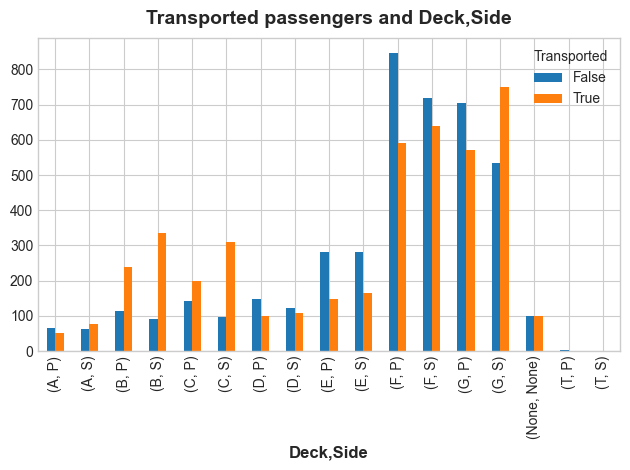

In [386]:
X_grouped = X.groupby(["Deck", "Side", "Transported"]).count()["PassengerId"].unstack()
X_grouped.plot(kind="bar", title="Transported passengers and Deck,Side")

## Impute values


In [387]:
def impute_cryosleep_expences(df):
    df_imputed = df.copy()
    expences = ["RoomService", "FoodCourt", "ShoppingMall", "Spa", "VRDeck"]
    df_imputed.loc[df_imputed[expences].sum(axis=1) == 0, "CryoSleep"] = True
    df_imputed.loc[df_imputed[expences].sum(axis=1) != 0, "CryoSleep"] = False
    df_imputed.loc[df_imputed["CryoSleep"] == True, expences] = 0

    return df_imputed


def label_encode_keeping_nulls(df):
    df_encoded = df.copy()
    for col in df.select_dtypes("category").columns:
        indx = df.loc[~df[col].isna(), col].index
        df_encoded[col] = df[col].astype("object")
        df_encoded.loc[indx, col] = df[col].cat.codes[indx]
    return df_encoded


def impute_using_group(df):
    df_groups = df.copy()

    df_groups["Group"] = df_groups.PassengerId.str[:4]
    df_groups = df_groups[df_groups.groupby(["Group"])["Group"].transform("count") > 1]
    df_encoded = label_encode_keeping_nulls(df_groups)

    features_impute = ["Cabin", "HomePlanet"]
    for feature in features_impute:
        features_knn = ["Group", feature]
        df_knn_encoded = df_encoded[features_knn]
        knn_imputer = KNNImputer(n_neighbors=1, weights="distance")
        df_knn_imputed = pd.DataFrame(
            knn_imputer.fit_transform(df_knn_encoded),
            columns=df_knn_encoded.columns,
            index=df_knn_encoded.index,
        )
        df_knn_imputed = df_knn_imputed.round(0)

        for name in features_knn[1:]:
            cat_items = dict(enumerate(df[name].cat.categories))
            df_knn_imputed[name] = df_knn_imputed[name].replace(cat_items)
            idx = df_groups[name].isna().index
            df.loc[idx, name] = df_knn_imputed.loc[idx, name]

    return df


def knn_impute(df, df_train=None):
    df_encoded = label_encode_keeping_nulls(df)

    std_scaler = StandardScaler()
    df_scaled = df_encoded.copy()
    df_scaled[df_scaled.columns] = std_scaler.fit_transform(df_encoded)

    knn_imputer = KNNImputer(weights="distance")
    knn_cat_features = ["VIP", "CryoSleep", "HomePlanet", "Destination"]
    if df_train is not None:
        knn_imputer.fit(df_scaled.loc[df_train.index])
    else:
        knn_imputer.fit(df_scaled)
    df_scaled[df_scaled.columns] = knn_imputer.transform(df_scaled)

    df_encoded[df_encoded.columns] = std_scaler.inverse_transform(df_scaled)

    df_encoded = df_encoded.round(0)
    for name in knn_cat_features:
        df_encoded[name] = (
            df_encoded[name].astype("category").cat.add_categories("None")
        )
        new_categories = df[name].astype("category").cat.categories
        df[name] = (
            df_encoded[name].astype("category").cat.rename_categories(new_categories)
        )

    num_features = df.select_dtypes("number").columns
    df[num_features] = df_encoded[num_features]

    return df

In [388]:
def impute(df_train, df_test=None):
    df = df_train.copy()
    if df_test is not None:
        df = pd.concat([df, df_test])
    y = df.pop(target)

    df = impute_cryosleep_expences(df)
    df = impute_using_group(df)

    feature_bfills = ["Cabin"]
    df[feature_bfills] = df[feature_bfills].fillna(method="bfill")

    if df_test is not None:
        df = knn_impute(df, df_train)
    else:
        df = knn_impute(df)

    for name in df.select_dtypes("number"):
        df[name] = df[name].fillna(0).astype("int")
    for name in df.select_dtypes(exclude=["number"]):
        if df[name].isna().sum() != 0:
            df[name] = df[name].fillna("None")
        else:
            df[name] = df[name].cat.remove_categories("None")

    df = pd.concat([df, y], axis=1)
    if df_test is not None:
        return df.loc[df_train.index, :], df.loc[df_test.index, :]

    return df

# Features engineering


In [389]:
def mathematical_transforms(df):
    X = pd.DataFrame()
    X["RS_FC_SM"] = df[["RoomService", "FoodCourt", "ShoppingMall"]].sum(axis=1)
    X["VR_SPA"] = df[["Spa", "VRDeck"]].sum(axis=1)
    X["Expences"] = df[
        ["RoomService", "FoodCourt", "ShoppingMall", "Spa", "VRDeck"]
    ].sum(axis=1)
    X["Ratio_VR_SPA"] = X["VR_SPA"] / X["Expences"]
    X["Ratio_RFS"] = X["RS_FC_SM"] / X["Expences"]

    X["Sleep_Side"] = df["CryoSleep"].cat.codes * df["Side"].cat.codes

    return X


def interactions(df):
    X = pd.DataFrame()

    dummies_sleep = pd.get_dummies(df.CryoSleep, prefix="CryoSleep_VR_SPA")
    sleep_VR_SPA = dummies_sleep.mul(df.VR_SPA, axis=0)

    dummies_sleep = pd.get_dummies(df.CryoSleep, prefix="CryoSleep_RFM")
    sleep_RFS = dummies_sleep.mul(df.RS_FC_SM, axis=0)

    X = pd.concat([sleep_VR_SPA, sleep_RFS], axis=1)

    return X


def break_down(df):
    X = pd.DataFrame()

    X[["Group", "Id"]] = df.PassengerId.str.split("_", expand=True)
    X["Group"] = X.Group.astype("int")
    X.pop("Id")

    X[["Deck", "Cabin_num", "Side"]] = df.Cabin.str.split("/", expand=True)
    X[["Deck", "Side"]] = X[["Deck", "Side"]].fillna("None")
    X.pop("Cabin_num")

    X[["First Name", "Surname"]] = df.Name.str.split(" ", expand=True).fillna("None")
    X.pop("First Name")
    for name in ["Deck", "Side", "Surname"]:
        X[name] = X[name].astype("category")

        if "None" not in X[name].cat.categories:
            X[name] = X[name].cat.add_categories("None")

    return X


def group_transform(df):
    X = pd.DataFrame()

    X["Diff_VR_SPA"] = df["VR_SPA"] - df.groupby(by=["CryoSleep"])["VR_SPA"].transform(
        "median"
    )
    X["Diff_RS_FC_SM"] = df["RS_FC_SM"] - df.groupby(by=["CryoSleep"])[
        "RS_FC_SM"
    ].transform("median")

    X["in_group"] = (df.groupby(["Group"])["Group"].transform("count") > 1).astype(
        "int"
    )

    return X

In [390]:
def label_encode(df):
    X = df.copy()
    for colname in X.select_dtypes(["category"]):
        X[colname] = X[colname].cat.codes
    return X


def create_dummies(df, features):
    X = pd.DataFrame()
    for name in features:
        X = pd.concat([X, pd.get_dummies(df[name], prefix=name).astype("int")], axis=1)
    return X

## K-Means clustering


In [391]:
def cluster_labels(df, features, n_clusters=20):
    X = df.copy()
    X_scaled = X.loc[:, features]
    X_scaled = (X_scaled - X_scaled.mean(axis=0)) / X_scaled.std(axis=0)
    kmeans = KMeans(n_clusters=n_clusters, n_init=50, random_state=0)
    X_new = pd.DataFrame()
    X_new["Clusters"] = kmeans.fit_predict(X_scaled)
    return X_new

# Create final feature set


In [392]:
def create_features(df, df_test=None):
    X = df.copy()
    y = X.pop(target)

    # Combine splits if test data is given
    #
    # If we're creating features for test set predictions, we should
    # use all the data we have available. After creating our features,
    # we'll recreate the splits.
    if df_test is not None:
        X_test = df_test.copy()
        if target in X_test.columns:
            X_test.pop(target)
        X = pd.concat([X, X_test])

    # Transformations
    X = X.join(break_down(X))
    X = X.join(mathematical_transforms(X))
    X = X.join(interactions(X))
    X = X.join(group_transform(X))

    X = label_encode(X)

    # Clustering
    cluster_features = [
        "CryoSleep",
        "Side",
        "Deck",
        "FoodCourt",
        "ShoppingMall",
        "Spa",
        "VRDeck",
    ]

    X = X.join(cluster_labels(X, cluster_features, n_clusters=10))

    # Create dummies
    features = ["Deck", "HomePlanet", "Destination", "Side"]
    X = X.join(create_dummies(X, features))
    X.drop(features, axis=1, inplace=True)

    # Drop categorical features that can be hardly match between train and test sets
    X.drop(["PassengerId", "Name", "Cabin", "Group", "Surname"], axis=1, inplace=True)

    # Reform splits
    if df_test is not None:
        X_test = X.loc[df_test.index, :]
        X.drop(df_test.index, inplace=True)

    if df_test is not None:
        return X, X_test
    else:
        return X

# Cross validation


In [393]:
def score_dataset(X, y, model=XGBClassifier(), features=None):
    score = []
    skf = StratifiedKFold(random_state=0, shuffle=True)
    for i, (train_index, test_index) in enumerate(skf.split(X, y)):
        X_train, X_test = X.loc[train_index], X.loc[test_index]
        y_train, y_test = y[train_index], y[test_index]

        X_train, X_test = impute(X_train, X_test)
        X_train, X_test = create_features(X_train, X_test)

        if features is not None:
            X_train, X_test = X_train[features], X_test[features]

        model_local = clone(model)
        model_local.fit(X_train, y_train)

        score.append(accuracy_score(model_local.predict(X_test), y_test))

    return score

# Hyperparameter Tuning


## XGBoost


In [394]:
# optuna.logging.set_verbosity(optuna.logging.WARNING)


def objective(trial):
    df_train = load_data(PATH, with_test=False)
    y_train = df_train.loc[:, target].astype("bool")

    xgb_params = dict(
        max_depth=trial.suggest_int("max_depth", 2, 10),
        learning_rate=trial.suggest_float("learning_rate", 1e-4, 1e-1, log=True),
        n_estimators=trial.suggest_int("n_estimators", 50, 5000),
        min_child_weight=trial.suggest_int("min_child_weight", 1, 10),
        colsample_bytree=trial.suggest_float("colsample_bytree", 0.2, 1.0),
        subsample=trial.suggest_float("subsample", 0.2, 1.0),
        reg_alpha=trial.suggest_float("reg_alpha", 1e-4, 1e1, log=True),
        reg_lambda=trial.suggest_float("reg_lambda", 1e-4, 1e1, log=True),
    )
    xgb = XGBClassifier(**xgb_params)

    return np.mean(score_dataset(df_train, y_train.astype("int"), xgb))


study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100)
xgb_params = study.best_params

[I 2023-08-18 15:00:06,515] A new study created in memory with name: no-name-8297742d-f147-4330-a423-133131ab599a
[I 2023-08-18 15:00:28,774] Trial 0 finished with value: 0.7996085868695618 and parameters: {'max_depth': 2, 'learning_rate': 0.028740791326773478, 'n_estimators': 767, 'min_child_weight': 5, 'colsample_bytree': 0.558092854418937, 'subsample': 0.2816682617906498, 'reg_alpha': 4.5251647921394955, 'reg_lambda': 0.12719022047277487}. Best is trial 0 with value: 0.7996085868695618.
[I 2023-08-18 15:00:49,413] Trial 1 finished with value: 0.8027148785295836 and parameters: {'max_depth': 4, 'learning_rate': 0.00972677986109082, 'n_estimators': 299, 'min_child_weight': 1, 'colsample_bytree': 0.890866984827396, 'subsample': 0.7297707161747322, 'reg_alpha': 0.11026564963386228, 'reg_lambda': 0.0038749213469742817}. Best is trial 1 with value: 0.8027148785295836.
[I 2023-08-18 15:01:07,271] Trial 2 finished with value: 0.7969615356364615 and parameters: {'max_depth': 10, 'learning_ra

In [395]:
print("The best parameters")
xgb_params

The best parameters


{'max_depth': 6,
 'learning_rate': 0.0005771388599831881,
 'n_estimators': 4307,
 'min_child_weight': 1,
 'colsample_bytree': 0.5994972428504902,
 'subsample': 0.7220573758692146,
 'reg_alpha': 0.004618052272676687,
 'reg_lambda': 0.0002648896440023188}

In [396]:
df_train = load_data(PATH, with_test=False)

y_train = df_train.loc[:, target].astype("bool")

# xgb_params = {
#     "max_depth": 6,
#     "learning_rate": 0.0011231556765223495,
#     "n_estimators": 4968,
#     "min_child_weight": 1,
#     "colsample_bytree": 0.6486673116722138,
#     "subsample": 0.5656591278713615,
#     "reg_alpha": 0.03102176365621891,
#     "reg_lambda": 0.06932993934004869,
# }

xgb = XGBClassifier(**xgb_params)

print(np.mean(score_dataset(df_train, y_train, xgb)))

0.8101908362344666


## Catboost


In [397]:
def objective(trial):
    params = dict(
        iterations=trial.suggest_int("iterations", 50, 1000),
        learning_rate=trial.suggest_float("learning_rate", 1e-3, 1e-1, log=True),
        depth=trial.suggest_int("depth", 4, 10),
        l2_leaf_reg=trial.suggest_float("l2_leaf_reg", 1e-8, 100.0, log=True),
        bootstrap_type=trial.suggest_categorical("bootstrap_type", ["Bayesian"]),
        random_strength=trial.suggest_float("random_strength", 1e-8, 10.0, log=True),
        bagging_temperature=trial.suggest_float("bagging_temperature", 0.0, 10.0),
        od_type=trial.suggest_categorical("od_type", ["IncToDec", "Iter"]),
        od_wait=trial.suggest_int("od_wait", 10, 50),
    )

    cat_boost = CatBoostClassifier(**params, verbose=0, random_seed=0)

    return np.mean(score_dataset(df_train, y_train.astype("int"), cat_boost))


study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100)
cat_boost_params = study.best_params

[I 2023-08-18 17:02:52,785] A new study created in memory with name: no-name-ff372295-b42e-4c83-9de5-c3843557ab32
[I 2023-08-18 17:03:11,820] Trial 0 finished with value: 0.7925914725537673 and parameters: {'iterations': 605, 'learning_rate': 0.06759361922002335, 'depth': 7, 'l2_leaf_reg': 1.1444330482667854e-08, 'bootstrap_type': 'Bayesian', 'random_strength': 5.589583784629328e-07, 'bagging_temperature': 7.712472810058642, 'od_type': 'Iter', 'od_wait': 17}. Best is trial 0 with value: 0.7925914725537673.
[I 2023-08-18 17:03:44,907] Trial 1 finished with value: 0.7946618925073005 and parameters: {'iterations': 386, 'learning_rate': 0.0010276460579308894, 'depth': 9, 'l2_leaf_reg': 1.5622217148470567, 'bootstrap_type': 'Bayesian', 'random_strength': 0.010946011999505324, 'bagging_temperature': 5.718965111531967, 'od_type': 'IncToDec', 'od_wait': 44}. Best is trial 1 with value: 0.7946618925073005.
[I 2023-08-18 17:04:44,644] Trial 2 finished with value: 0.7877596544712084 and parameter

In [398]:
print("The best parameters")
cat_boost_params

The best parameters


{'iterations': 335,
 'learning_rate': 0.037273721103051875,
 'depth': 5,
 'l2_leaf_reg': 2.865852982377371,
 'bootstrap_type': 'Bayesian',
 'random_strength': 1.5309957644193485e-07,
 'bagging_temperature': 0.31059750946637094,
 'od_type': 'IncToDec',
 'od_wait': 22}

In [399]:
df_train = load_data(PATH, with_test=False)

y_train = df_train.loc[:, target].astype("int")

# cat_boost_params = {
#     "iterations": 604,
#     "learning_rate": 0.008574858135413305,
#     "depth": 6,
#     "l2_leaf_reg": 0.024986714637090388,
#     "bootstrap_type": "Bayesian",
#     "random_strength": 3.700277878995026e-05,
#     "bagging_temperature": 0.027325609307599474,
#     "od_type": "Iter",
#     "od_wait": 39,
# }

cat_boost = CatBoostClassifier(**cat_boost_params, verbose=0)

print(np.mean(score_dataset(df_train, y_train, cat_boost)))

0.8115711382611464


# Train model and create submission


In [400]:
df_train, df_test = load_data(PATH)
target = "Transported"
X_train, X_test = impute(df_train, df_test)
X_train, X_test = create_features(X_train, X_test)
y_train = df_train.loc[:, target].astype("int").to_numpy()

cat_boost = CatBoostClassifier(**cat_boost_params, verbose=0)
cat_boost.fit(X_train, y_train)
predictions = cat_boost.predict(X_test).astype("bool")

output = pd.DataFrame(
    {"PassengerId": df_test.PassengerId, "Transported": predictions.squeeze()}
)

output.to_csv("submission.csv", index=False)